In [1]:
import torch
import torch.nn as nn
from torch.distributions import Categorical
import torch.nn.functional as F
import torch.optim as optim

import gymnasium as gym
from minigrid.wrappers import ImgObsWrapper
import time

pygame 2.5.2 (SDL 2.28.3, Python 3.10.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
import matplotlib.pyplot as plt

In [3]:
import torch
import torch.nn as nn
from torch.distributions import Categorical
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

class ACModel(nn.Module):
    def __init__(self, input_dim, action_dim, mem_out_size=128, activation=nn.ReLU()):
        super(ACModel, self).__init__()    
        self.conv = Conv_unit(input_dim, [16, 32], 64, nn.ReLU()) 
        dim_out_conv = self.conv.get_conv_out_shape(input_dim)
        
        self.memory = nn.LSTM(dim_out_conv, mem_out_size)

        self.fc_pi = nn.Sequential(
            nn.Linear(mem_out_size,64),
            activation,
            nn.Linear(64, action_dim)
        )
        
        self.fc_v = nn.Sequential(
            nn.Linear(mem_out_size,64),
            activation,
            nn.Linear(64, 1)
        )
               
    def forward(self, *args):
        x = args[0]
        h_in, c_in = args[-2:]
        
        x = self.conv(x)
        out, (h_out, c_out) = self.memory(x, (h_in, c_in))
        
        v = self.fc_v(out)
        pi = self.fc_pi(out)
        pi = F.softmax(pi, dim=2).squeeze(1)
        
        return pi, v, h_out, c_out

class Conv_unit(nn.Module):
    def __init__(self, input_dim, conv_dims, output_dim, activation=nn.ReLU()):
        super(Conv_unit, self).__init__()
        
        self.output_dim = output_dim
        
        conv_dims.insert(0, input_dim[0])
        conv_dims.append(output_dim)
        conv_module_list = []
        for i in range(len(conv_dims) - 1):
            conv_module_list.append(nn.Conv2d(conv_dims[i], conv_dims[i + 1], 2, 1))
            conv_module_list.append(activation)
        self.seq = nn.Sequential(*conv_module_list)
        
    def get_conv_out_shape(self, input_dim):
        x = torch.zeros([1, *input_dim])
        x = self.seq(x)
        return np.prod(x.shape)
    
    def forward(self, x):
        x = self.seq(x).view(x.size()[0], 1, -1)
        return x

In [4]:
args = {
    'gamma': 0.99,
    'lmbda': 0.95,
    'eps_clip': 0.1,
    'entropy_beta' : 0.01,
    'lr': 5e-4,
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

envs = {1:['MiniGrid-Empty-8x8-v0', {0:0, 1:1, 2:2}],
        2:['MiniGrid-FourRooms-v0', {0:0, 1:1, 2:2}],
        3:['MiniGrid-DoorKey-6x6-v0', {0:0, 1:1, 2:2, 3:3, 4:5}],
        4:['MiniGrid-DoorKey-16x16-v0', {0:0, 1:1, 2:2, 3:3, 4:5}]
       }

In [6]:
def prepare_state(x):
    "Normalizes the state tensor and converts it to a PyTorch tensor"
    ns = torch.from_numpy(x).float().permute(2,0,1).unsqueeze(dim=0).to(args['device'])
    maxv = ns.flatten().max()
    ns = ns / maxv
    return ns

env_id = 3
env = ImgObsWrapper(gym.make(envs[env_id][0]))
state, _ = env.reset()
state = prepare_state(state)

args['n_act'] = len(envs[env_id][1])

In [7]:
args

{'gamma': 0.99,
 'lmbda': 0.95,
 'eps_clip': 0.1,
 'entropy_beta': 0.01,
 'lr': 0.0005,
 'device': device(type='cpu'),
 'n_act': 5}

In [8]:
def train(net, buffer):
    new_buffer = list(zip(*buffer))
    state_batch = torch.stack(new_buffer[0]).squeeze().to(args['device'])
    state_batch = state_batch.reshape(-1, *state_batch.shape[-3:])
    rew_batch = np.array(new_buffer[1])
    new_state_batch = torch.stack(new_buffer[2]).squeeze().to(args['device'])
    new_state_batch = new_state_batch.reshape(-1, *new_state_batch.shape[-3:])
    pi_batch = torch.cat(new_buffer[3]).to(args['device'])
    action_batch = np.array(new_buffer[4]) 

    h_in = new_buffer[5][0].detach()
    c_in = new_buffer[6][0].detach()
    h_out = new_buffer[7][0].detach()
    c_out = new_buffer[8][0].detach() 
    
    assert np.sum(np.array(new_buffer[9])) == 1
    done_mask = torch.FloatTensor(1 - np.array(new_buffer[9])).to(args['device'])
  
    with torch.no_grad():
        _, v_prime, _, _ = net(new_state_batch, h_out, c_out)
    td_target = (torch.FloatTensor(rew_batch).to(args['device']) + 
                 args['gamma'] * v_prime.squeeze() * done_mask.squeeze())
    for i in range(2):
        pi, v, _, _ = net(state_batch, h_in, c_in)   
        delta = td_target - v.squeeze()
        delta = delta.detach().cpu().numpy()
        advantage_lst = []
        advantage = 0.0
        for item in delta[::-1]:
            advantage = args['gamma'] * args['lmbda'] * advantage + item
            advantage_lst.append([advantage])
        advantage_lst.reverse()
        advantage = torch.FloatTensor(advantage_lst).squeeze().to(args['device'])
        pi_a = pi.gather(1, torch.tensor(action_batch, dtype=torch.int64).to(args['device'])).squeeze() 
        #print((pi_a - pi_batch).sum())   
        ratio = torch.exp(torch.log(pi_a) - torch.log(pi_batch))  # a/b == exp(log(a)-log(b))
        surr1 = ratio * advantage
        surr2 = torch.clamp(ratio, 1-args['eps_clip'], 1+args['eps_clip']) * advantage

        # Entropy loss
        entropy = (torch.log(pi) * pi).sum(dim=1).mean()
        entropy_loss = args['entropy_beta'] * entropy

        loss = (-torch.min(surr1, surr2) + 
                F.smooth_l1_loss(v.squeeze(), td_target.detach().squeeze()) + 
                entropy_loss)

        optimizer.zero_grad()
        loss.mean().backward(retain_graph=False)
        optimizer.step() 


    return net

In [9]:
action_map = envs[env_id][1]

net = ACModel(state.shape[1:], args['n_act'], 128, nn.Tanh()).to(args['device'])

optimizer = optim.Adam(net.parameters(), lr=args['lr'])

all_rews = []

In [ ]:
#net.load_state_dict(torch.load(f'../models/model_PPO_lstm_{envs[env_id][0]}_1.pt'))

In [10]:
net

ACModel(
  (conv): Conv_unit(
    (seq): Sequential(
      (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
      (3): ReLU()
      (4): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
      (5): ReLU()
    )
  )
  (memory): LSTM(1024, 128)
  (fc_pi): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=5, bias=True)
  )
  (fc_v): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [12]:
start = time.time()

for epoch in range(4900):
    h_in = torch.zeros([1, 1, 128]).to(args['device'])
    c_in = torch.zeros([1, 1, 128]).to(args['device'])
    state, _ = env.reset()
    state = prepare_state(state)
    done = False
    buffer = [] 
    counter = 0
    tot_rew = 0
    while not done:
        counter += 1
        with torch.no_grad():
            pi, v, h_out, c_out = net(state, h_in, c_in)
        prob = Categorical(pi.squeeze())
        action = prob.sample().item()
        new_state, rew, done, _, _ = env.step(action_map[action])
        if rew == 0:
            rew = -0.1
        new_state = prepare_state(new_state)
        tot_rew += rew
        
        if counter >= 400:
            done = True
        # Save in the buffer
        action = np.array([action])
        buffer.append([state, rew/10, new_state, 
                       pi[:,action[0]].detach(),
                       action, 
                       h_in, c_in, h_out, c_out, done])
        
        h_in, c_in = h_out, c_out
        state = new_state
    net = train(net, buffer)
    all_rews.append(tot_rew)
    if (epoch % 10 == 0) and (epoch > 0):
        print('Epoch:', epoch,
              'Avg Rew:', np.round(np.mean(all_rews[-10:]), 3))
    if np.mean(all_rews[-10:]) > -1.0:
        break
print('Total time:', time.time() - start)

Epoch: 10 Avg Rew: -31.473
Epoch: 20 Avg Rew: -36.577
Epoch: 30 Avg Rew: -34.404
Epoch: 40 Avg Rew: -36.352
Epoch: 50 Avg Rew: -33.298
Epoch: 60 Avg Rew: -36.649
Epoch: 70 Avg Rew: -39.642
Epoch: 80 Avg Rew: -34.21
Epoch: 90 Avg Rew: -35.675
Epoch: 100 Avg Rew: -34.384
Epoch: 110 Avg Rew: -33.523
Epoch: 120 Avg Rew: -31.955
Epoch: 130 Avg Rew: -39.56
Epoch: 140 Avg Rew: -38.525
Epoch: 150 Avg Rew: -38.443
Epoch: 160 Avg Rew: -33.236
Epoch: 170 Avg Rew: -38.637
Epoch: 180 Avg Rew: -31.77
Epoch: 190 Avg Rew: -33.595
Epoch: 200 Avg Rew: -36.311
Epoch: 210 Avg Rew: -27.64
Epoch: 220 Avg Rew: -29.618
Epoch: 230 Avg Rew: -33.779
Epoch: 240 Avg Rew: -31.043
Epoch: 250 Avg Rew: -36.454
Epoch: 260 Avg Rew: -32.847
Epoch: 270 Avg Rew: -34.169
Epoch: 280 Avg Rew: -25.693
Epoch: 290 Avg Rew: -20.958
Epoch: 300 Avg Rew: -28.911
Epoch: 310 Avg Rew: -35.696
Epoch: 320 Avg Rew: -34.292
Epoch: 330 Avg Rew: -37.028
Epoch: 340 Avg Rew: -26.349
Epoch: 350 Avg Rew: -20.896
Epoch: 360 Avg Rew: -25.15
Epoch:

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


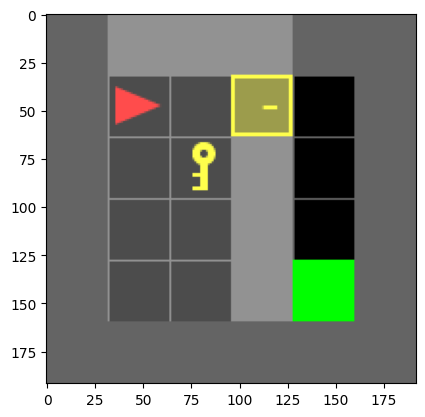

In [13]:
state = env.reset()
plt.imshow(env.get_frame())
plt.show()

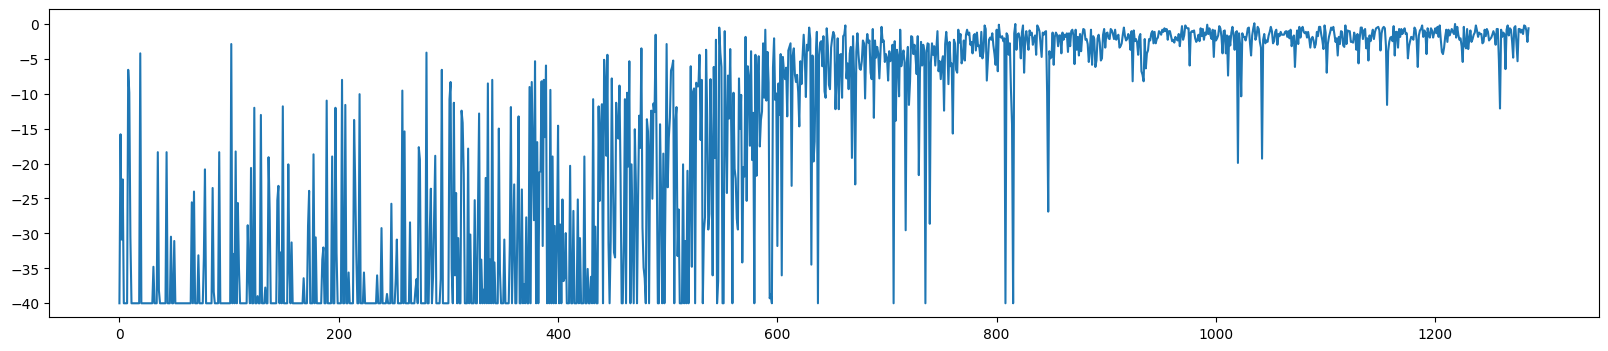

In [14]:
plt.figure(figsize=(20, 4))
plt.plot(all_rews)

In [ ]:
torch.save(net.state_dict(), f'models/Agent_{envs[env_id][0]}_1.pt')
torch.save(optimizer.state_dict(), f'models/Optimizer_{envs[env_id][0]}_1.pt')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.grid to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.grid` for environment variables or `env.get_wrapper_attr('grid')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.agent_pos to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.agent_pos` for environment variables or `env.get_wrapper_attr('agent_pos')` that will search the reminding wrappers.
  logger.warn(


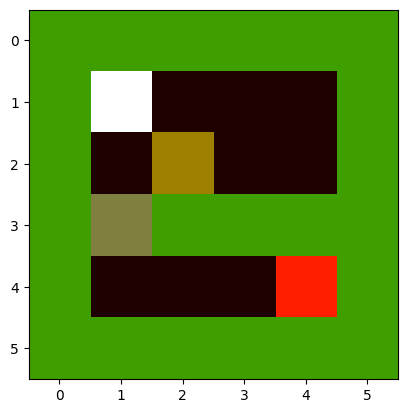

In [15]:
env_map = (255*(env.grid.encode()/8)).astype(int)
env_map[env.agent_pos] = [255, 255, 255]
plt.imshow(env_map);